### Plotting Data

In [1]:
# Import required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Read csv file into pandas dataframe 
sales_df = pd.read_csv('us_retail_sales.csv')

In [3]:
# Display first 3 rows
sales_df.head(3)

,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
0,1992,146925,147223,146805,148032,149010,149800,150761.0,151067.0,152588.0,153521.0,153583.0,155614.0
1,1993,157555,156266,154752,158979,160605,160127,162816.0,162506.0,163258.0,164685.0,166594.0,168161.0
2,1994,167518,169649,172766,173106,172329,174241,174781.0,177295.0,178787.0,180561.0,180703.0,181524.0


In [4]:
# Reshape dataframe from wide to long
sales_long = pd.melt(sales_df, 
                     id_vars='YEAR', 
                     value_vars=['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP','OCT', 'NOV', 'DEC'],
                     var_name='MONTH', value_name='SALES')

In [5]:
# Convert Month names to numbers
month_list=['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP','OCT', 'NOV', 'DEC']
month_num=[1,2,3,4,5,6,7,8,9,10,11,12]
sales_long['MONTH'] = sales_long['MONTH'].replace(month_list, month_num)

In [6]:
# Reorganize by year
sales_long=sales_long.sort_values(by='YEAR')

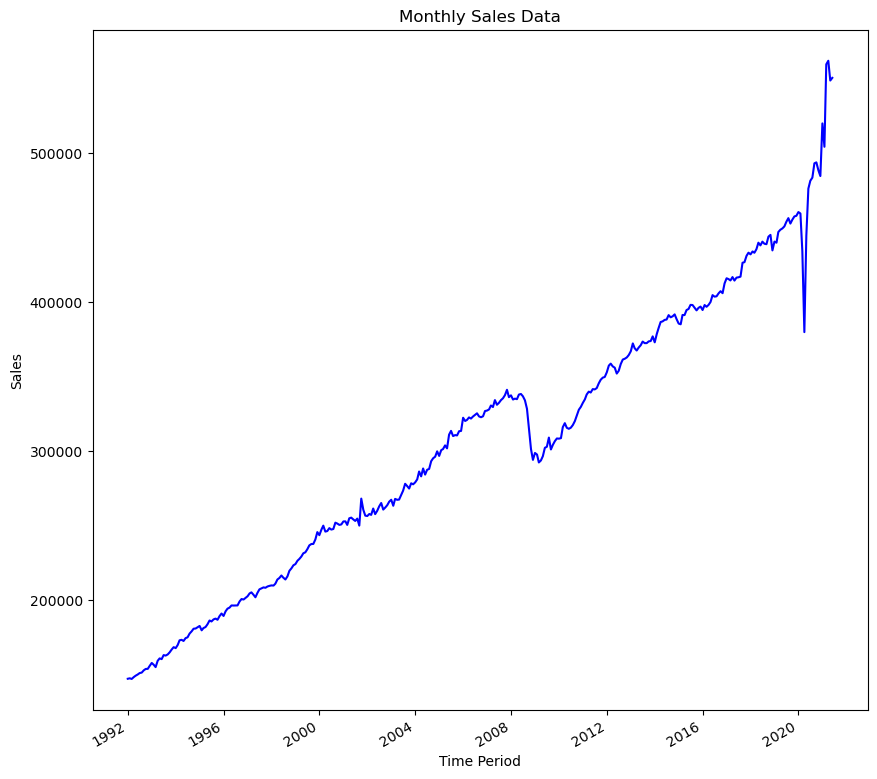

In [7]:
# Plot Monthly Sales Data Time Series
ax = sales_long.set_index(pd.to_datetime(sales_long[['YEAR','MONTH']].assign(day=1)))['SALES']\
       .plot(color='b', figsize=(10,10), title='Monthly Sales Data')
_ = ax.set_xlabel('Time Period')
_ = ax.set_ylabel('Sales')


### Observations

Aside from two rather sharp periods of decreasing sales in 2008 and 2020, sales have overall trended as increasing. There does not appear to be any seasonality to this spending. These two decreased sales periods do coincide with both the 2008 recession period and the height of the COVID-19 pandemic where spending on non-essentials was likely low due to issues which spanned everything from employment to housing security.

### Splitting Data for Modeling

In [8]:
# Create new Date column from Month/Year columns
sales_long['DATE'] =  pd.to_datetime(dict(year=sales_long.YEAR, month=sales_long.MONTH, day=1))

In [9]:
# Drop rows with NA values
sales_long = sales_long.dropna()

In [10]:
# Reorganize by date
sales_long=sales_long.sort_values(by='DATE')
sales_long=sales_long.reset_index(drop=True)

In [11]:
# Create new dataframe dropping year and month columns
sales_date = sales_long.drop(['YEAR','MONTH'], axis=1)

In [12]:
# Set index for this new dataframe as the date column
sales_date=sales_date.set_index('DATE')

In [13]:
df_train = sales_date.head(-12)
df_test = sales_date.tail(12)

In [14]:
# Import the library
from pmdarima.arima import auto_arima

# Build and fit the AutoARIMA model
model = auto_arima(df_train, 
                   seasonal=True, 
                   m=12, 
                   suppress_warnings=True)
model.fit(df_train)

# Check the model summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  342
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -3442.364
Date:                Sun, 30 Jul 2023   AIC                           6888.728
Time:                        12:27:23   BIC                           6896.392
Sample:                    01-01-1992   HQIC                          6891.781
                         - 06-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    966.0352    322.194      2.998      0.003     334.547    1597.524
sigma2      3.434e+07    4.6e+05     74.719      0.000    3.34e+07    3.52e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):             61070.32
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):              34.11   Skew:                             1.42
Prob(H) (two-sided):                  0.00   Kurtosis:                        68.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

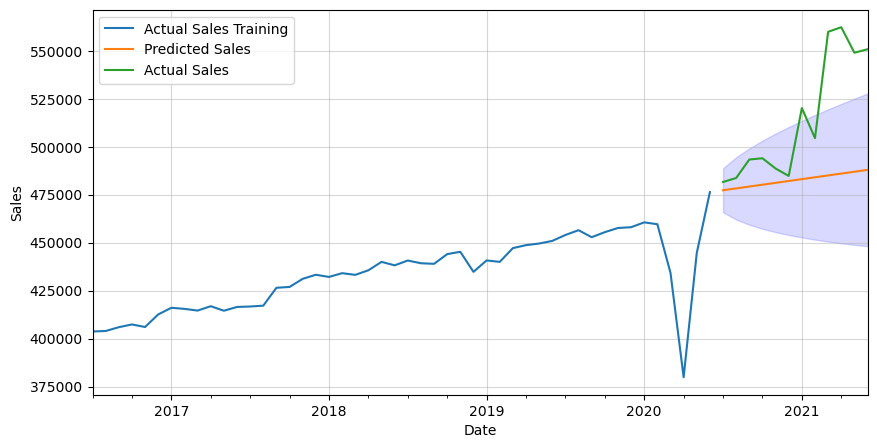

In [15]:
# Make predictions for last year
preds_auto, conf_int_auto = model.predict(n_periods=12,
                                             return_conf_int=True)

# Get sales predictions and confidence intervals for 1 year
preds_values_auto = preds_auto
confidence_intervals_auto = conf_int_auto

# Plot with training data
ax = df_train[-12*4:].plot(figsize=(10,5))
preds_auto.plot(ax=ax)
df_test.plot(ax=ax)
plt.fill_between(preds_values_auto.index, 
                 confidence_intervals_auto[:,[0]].flatten(), 
                 confidence_intervals_auto[:,[1]].flatten(), 
                 color='blue',
                 alpha=0.15)
plt.legend(['Actual Sales Training', 
            'Predicted Sales', 
            'Actual Sales'], 
           loc='upper left')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(alpha=0.5)
plt.show()

In [16]:
# Predicted values and actual values
predicted_values_auto = preds_auto.values
actual_values = df_test.values.flatten()

# Root Mean Squared Error (RMSE)
mse = np.mean((predicted_values_auto - actual_values) ** 2)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

RMSE: 42328.87118594068


As we can see from the above the RMSE is very high, and this model underpredicts the sales for the last year compared to how sales actually performed.